# Creative Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [54]:
import requests
import os

def download_file(book_name):
    base_url = "https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/"
    file_url = base_url + book_name
    local_filename = book_name

    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_filename, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Downloaded {book_name} successfully!")
        return local_filename
    else:
        raise ValueError("Failed to download the file. Please check the filename and try again.")

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Prompt user to select a book
title_options = {
    "1": "charles_dickens.txt",
    "2": "mark_twain.txt",
    "3": "shakespeare.txt"
}

print("Choose a book to download:")
print("1: Charles Dickens")
print("2: Mark Twain")
print("3: William Shakespeare")

choice = None
while choice not in title_options:
    choice = input("Enter the number corresponding to your choice (1, 2, or 3): ").strip()
    if choice not in title_options:
        print("Invalid choice. Please enter 1, 2, or 3.")

selected_book = title_options[choice]
file_path = download_file(selected_book)

# Load chosen dataset
fraction = 0.05  # Adjust fraction if running out of memory  # adjusted from 0.1 to 0.05 due to trained model constantly being out of memory
text = load_dataset(file_path, fraction=fraction)

print("Dataset loaded successfully!")

Choose a book to download:
1: Charles Dickens
2: Mark Twain
3: William Shakespeare
Enter the number corresponding to your choice (1, 2, or 3): 3
Downloaded shakespeare.txt successfully!
Dataset loaded successfully!


# 1. Data Preparation (10 Marks)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration (3 Marks)

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [55]:
# Solution
print(text[:1000])
print('The dataset contains {} characters.'.format(len(text)))
unique_chars = sorted(set(text))
print('The dataset contains {} unique characters.'.format(len(unique_chars)))

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic version
    the footnotes 

## 1.2 Text Pre-Processing (4 Marks)

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [56]:
# Solution
from tensorflow.keras.preprocessing.text import Tokenizer

# Convert the entire text to lowercase
text = text.lower()
VOCAB_SIZE = 5000
OOV_TOKEN = "<OOV>"

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

tokenizer.fit_on_texts([text])
#Convert text into sequences of numbers
text_sequences = tokenizer.texts_to_sequences([text])

print(len(tokenizer.word_index))


8820


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [57]:
print(list(tokenizer.word_index.items())[:10])

[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('i', 7), ('in', 8), ('you', 9), ('my', 10)]


## 1.3 Sequence Generation (3 Marks)

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [58]:
# Solution
SEQ_LENGTH = 5

# Convert the text to a list of sequences of numbers

sequences = tokenizer.texts_to_sequences([text])
sequences = sequences[0]

# Generate the training sequences
X = []
y = []

for i in range(len(sequences) - SEQ_LENGTH):
    X.append(sequences[i:i + SEQ_LENGTH])  # Sequence length SEQ_LENGTH
    y.append(sequences[i + SEQ_LENGTH])    # target next word


print(X[0])
print(y[0])

[2, 58, 56, 374, 4]
93


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [59]:
print(f'Sequence: {X[0]}\nTarget: {y[0]}')
print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')

Sequence: [2, 58, 56, 374, 4]
Target: 93
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of'] -> hamlet


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [60]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
mask = y != tokenizer.word_index[OOV_TOKEN]
X = X[mask]
y = y[mask]

# One-hot encode the target token
y = to_categorical(y, num_classes=VOCAB_SIZE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (58780, 5)
y_train shape: (58780, 5000)


# 2. Model Development (10 Marks)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture (4 Marks)

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=SEQ_LENGTH),
LSTM(units=128, return_sequences=False),
Dense(units=VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before printing the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation (3 Marks)

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

loss function - categorical cross-entropy as it is suitable for multi-class classification, as it predicts probability distribution over a vocabulary of words
Optimizer  - adam as the learning rate is adaptive and helps the model converge faster.


In [62]:
# Solution
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 2.3 Model Training (3 Marks)

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [63]:
#load the saved model (in case google colab ran out of ram)
#model = keras.models.load_model('assignment2pretrain.keras')

# Train the model
#history = model.fit(X_train,y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))
history = model.fit(X_train,y_train, epochs=5, batch_size=128, validation_data=(X_val,y_val))


Epoch 1/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0369 - loss: 7.2878 - val_accuracy: 0.0431 - val_loss: 6.6691
Epoch 2/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0446 - loss: 6.5754 - val_accuracy: 0.0557 - val_loss: 6.6002
Epoch 3/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0562 - loss: 6.4131 - val_accuracy: 0.0718 - val_loss: 6.4285
Epoch 4/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0743 - loss: 6.1604 - val_accuracy: 0.0825 - val_loss: 6.2422
Epoch 5/5
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0918 - loss: 5.8822 - val_accuracy: 0.0925 - val_loss: 6.1444


In [64]:
# Save the trained model in case it crashes later
model.save('assignment2train.keras')

Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

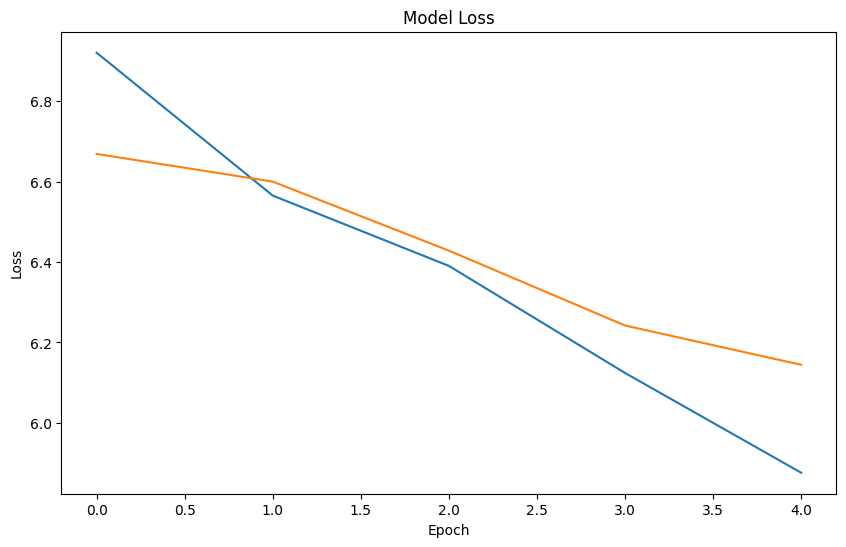

In [65]:
# Solution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend
plt.show()


# 3. Text Generation (10 Marks)

## Task Overview

In this task, you will write a function called `generate_text` that uses a trained RNN model to generate new text based on a given seed phrase.

Your function **must** follow a structured approach to text generation, where the model predicts one word at a time, adds it to the sequence, and repeats this process until a desired length is reached.

## Function Requirements

You need to implement a function with the following signature:

```python
def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
```

### **Parameters**
- `model`: The trained RNN model that will generate text.
- `tokenizer`: The tokenizer used to convert words to numerical sequences.
- `seed_text`: The initial text that will be used to start generating words.
- `max_sequence_len`: The maximum length of input sequences (same as used in training).
- `n_words` (optional, default=100): The number of words to generate.

### **Expected Output**
- A single **string** containing the generated text.

---

## **Step-by-Step Instructions**

### **1. Tokenize the seed text**
Use the tokenizer to convert `seed_text` into a sequence of numbers:

```python
encoded = tokenizer.texts_to_sequences([seed_text])[0]
```

### **2. Pad the sequence to match training input length**
Ensure that the sequence is the correct length by padding it **at the beginning**:

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
```

### **3. Predict the next word**
Pass the padded sequence to the model to predict the next word.

- The model will output a probability distribution over the vocabulary.
- Use `np.random.choice` or `np.argmax` to select the most likely word.

```python
yhat = model.predict(encoded, verbose=0)
predicted_word_index = np.argmax(yhat)  # Select the word with the highest probability
```

### **4. Convert the predicted word index to a word**
Find the corresponding word in the tokenizer’s vocabulary:

```python
out_word = tokenizer.index_word[predicted_word_index]
```

### **5. Append the new word to the generated text**
- Add the predicted word to `seed_text`.
- Repeat the process to generate multiple words.

```python
seed_text += " " + out_word
```

### **6. Repeat Steps 3-5 until `n_words` have been generated**

- Each time, remove the oldest word from the input sequence to keep its length constant.
- Continue generating words one at a time until reaching `n_words`.

---

## **Important Notes**
- If the generated text doesn’t make much sense, don’t worry! The quality will improve as the model is trained better.
- This is a **challenging** task! If you get stuck, ask for help.
- The `generate_text` function should return the **full generated text as a single string**.

### **Example Usage**
After implementing `generate_text`, you should be able to call it like this:

```python
generated_text = generate_text(model, tokenizer, "Once upon a time", max_sequence_len=20, n_words=50)
print(generated_text)
```

This should output a string of 50 words generated by the model, starting with `"Once upon a time"`.

In [66]:
# Solution

from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text(model,tokenizer,seed_text,max_sequence_len,n_words=100):
    encoded = tokenizer.texts_to_sequences([seed_text])[0]
    encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
    generated_text = seed_text
    for _ in range(n_words):
        yhat = model.predict(encoded,verbose=0)
        predicted_word_index = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

        out_word = tokenizer.index_word.get(predicted_word_index,'')
        generated_text += ' ' + out_word
    return generated_text


In [67]:
# Test the text generation function
#generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

generated_text = generate_text(model, tokenizer, "Once upon a time", max_sequence_len=20, n_words=50)
print(generated_text)

Once upon a time to did more and donations for 50 off with and and 170 50 a and off thou 1 f1 the trin hor like malone for and and do now holds like ship to for and was paid state i for and footnote the when but to to 31 after in


# 4. Model Refinement (5 Marks)

## **Understanding Your Model's Performance**

At this stage, you might have noticed that the text generated by your model doesn’t make much sense yet. **This is completely expected!**

There are a few reasons why:
1. **RNNs have limitations** – While they can generate sequences, they struggle with long-range dependencies in text.
2. **Character-by-character generation is outdated** – Modern models like ChatGPT don’t generate text one letter at a time. Instead, they use **tokens**, which represent larger chunks of words, making their outputs much more coherent.
3. **Training time and data size** – Our model has been trained on a relatively small dataset for a short period of time, which means it hasn’t learned enough patterns to generate meaningful text.

Even though we don’t expect ChatGPT-level performance, this exercise is about **experimentation, not perfection**. Your goal here is to try **at least one** way to refine your model and observe how it affects the output.

---

## **Refining Your Model**
There are many ways to try improving your model. Here are some ideas:

✅ **Use pre-trained embeddings**  
   Instead of learning word representations from scratch, you can use pre-trained word embeddings. This allows your model to start with a better understanding of word relationships.

✅ **Modify the model architecture**  
   - Experiment with **more layers** or different numbers of units per layer.  
   - Try adding **dropout layers** to prevent overfitting.  
   - Consider using **bidirectional RNNs**, which process text in both forward and backward directions.  

✅ **Train for longer**  
   - Try increasing the number of **epochs** (but be mindful of overfitting).  
   - Experiment with different **batch sizes** to see if they affect training stability.  

Again, **perfection is NOT the goal here** – we just want to see that you experimented with improving your model! 🚀

In [25]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-10 06:37:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 3m 4s   

2025-03-10 06:40:57 (4.48 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [71]:
# Load the pre-trained embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [69]:
# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [70]:
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], trainable=False
)

In [72]:
# Solution

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
import numpy as np

model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Dropout(0.2),
    LSTM(units=128),
    Dropout(0.2),
    Dense(units=VOCAB_SIZE, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.0333 - loss: 7.1191 - val_accuracy: 0.0529 - val_loss: 6.6549
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0549 - loss: 6.5420 - val_accuracy: 0.0701 - val_loss: 6.3911
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0704 - loss: 6.2400 - val_accuracy: 0.0839 - val_loss: 6.2064
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.0853 - loss: 5.9873 - val_accuracy: 0.0929 - val_loss: 6.0821
Epoch 5/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0960 - loss: 5.7916 - val_accuracy: 0.0970 - val_loss: 6.0140
Epoch 6/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.0998 - loss: 5.6374 - val_accuracy: 0.1040 - val_loss: 5.9448
Epoch 7/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1059 - loss: 5.4761 - val_accuracy: 0.1060 - val_loss: 5.9106
Epoch 8/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.1137 - loss: 5.3228 - val_acc

In [73]:
# Test the text generation function
generate_text(model, tokenizer, 'Once upon a time', SEQ_LENGTH)



"Once upon a time their which bee to osr thou before and mast memory hearing fair 20 besides of 5 design can fellow his news to after do well but compass further might of would fancies calls digger should ghost cannot of to of the of willing ari milan she trin will looked masters under they of in was and ham to which can fer wounded he’s hardly o’er footnote she tree grew island “well whether remembrance orlando deserv’d of 32 mark to settled from of hamlet's he’s answer of ari be again for requirements for that foul ” would invulnerable expression of let"

In [74]:
# try to fine tune settings

model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(units=256, return_sequences=True)),
    Dropout(0.1),
    LSTM(units=256),
    Dropout(0.1),
    Dense(units=VOCAB_SIZE, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_val, y_val)
)



Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.0373 - loss: 7.1768 - val_accuracy: 0.0495 - val_loss: 6.6721
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0523 - loss: 6.5690 - val_accuracy: 0.0693 - val_loss: 6.4022
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0731 - loss: 6.2250 - val_accuracy: 0.0829 - val_loss: 6.2189
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.0844 - loss: 5.9972 - val_accuracy: 0.0946 - val_loss: 6.1004
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0946 - loss: 5.7698 - val_accuracy: 0.1004 - val_loss: 6.0039
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1022 - loss: 5.5729 - val_accuracy: 0.1042 - val_loss: 5.9422
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1101 - loss: 5.3996 - val_accuracy: 0.1098 - val_loss: 5.8876
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1191 - loss: 5.2118 - val_acc

In [75]:
# Test the text generation function
generate_text(model, tokenizer, 'Once upon a time', SEQ_LENGTH)

"Once upon a time as text we of footnote ” days appointed since and made ” mar seem after it states ff of of as if but he here’s for of but will without footnote of 106 two don if were graves never the of 15 whose are now 20 of envenom'd he they after who met are when in doth with of shall and every not in of man ” once it after of but and that time genius when was they hath magistrate of longer and this but and than when is stroke sir so would ourselves 170 are he were came"